# Chapter 3. Classification

## MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
print(f"X dimensions: {X.shape}")
print(f"y dimensions: {y.shape}")

X dimensions: (70000, 784)
y dimensions: (70000,)


#### This means there are 70,000 images and each image has 784 features (all in one row) which we can reshape as a 28x28 array
#### Let's display the image using matplotlib

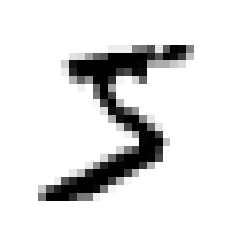

In [51]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
# Let's see what information the taget label  holds
import numpy as np

y = y.astype(np.uint8)
print("label for some_digit:", y[0])

label for some_digit: 5


#### MNIST dataset is already split into training and testing datasets

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

#### "5-detector": binary classifier that distinguishes between 5 and not-5

In [54]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#### Let's pick a classifier and train it: Stochastic Gradient Descent

In [55]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [56]:
# Let's test it
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

In [57]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.87082583, 0.87089354, 0.88628294])

In [58]:
# Very good results, let's see the results also for a dumb classifier
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.91125, 0.90855, 0.90915])

#### Obviously there is something wrong here, there are just 10% of 5s so 90% of the time you will be right

## Confusion Matrix

In [59]:
# Let's compute some predictions
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

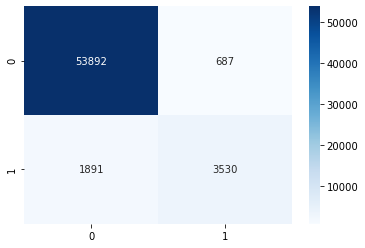

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

conf_mtrx = confusion_matrix(y_train_5, y_train_pred)
sn.heatmap(conf_mtrx, annot=True, cmap='Blues', fmt='g')

## Precision and Recall

In [61]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))

Precision: 0.8370879772350012
Recall: 0.6511713705958311


#### For a single value metric let's use the harmonic mean, F1 score

In [62]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## Precision/Recall Tradeoff

#### Let's try to move the threshold in order to change recall and precision values

In [63]:
# Let's check the score for one value
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [64]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [65]:
#### SGDC Classifier uses threshold = 0, so let's raise this value
threshold = 8000
y_some_digit = (y_scores > threshold)
y_some_digit

array([False])

#### Raising the threshold decreases the recall

In [66]:
# Let's get the score of all instances
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function", n_jobs=-1)

#### With this scores you can plot all the precision/recall values for every threshold value

In [67]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

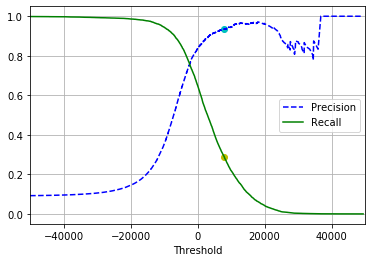

In [68]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.scatter(threshold, precisions[np.searchsorted(thresholds, threshold)], c="c")
    plt.scatter(threshold, recalls[np.searchsorted(thresholds, threshold)], c="y")
    plt.xlabel("Threshold")
    plt.xlim(-50000, 50000)
    plt.legend()
    plt.grid()
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#### Another way to select a good threshold is to plot recall vs precision

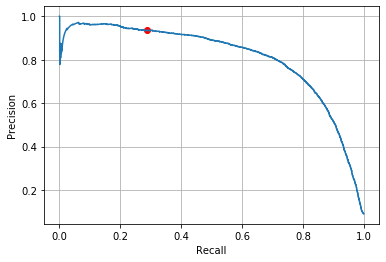

In [69]:
def plot_recall_vs_precision(recalls, precisions):
    plt.plot(recalls, precisions)
    plt.scatter(recalls[np.searchsorted(thresholds, threshold)], precisions[np.searchsorted(thresholds, threshold)], c="r")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.show()
    
plot_recall_vs_precision(recalls, precisions)

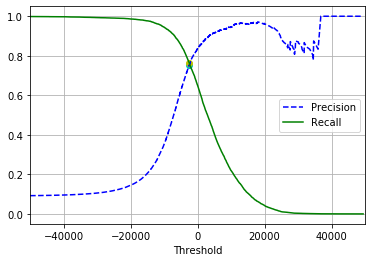

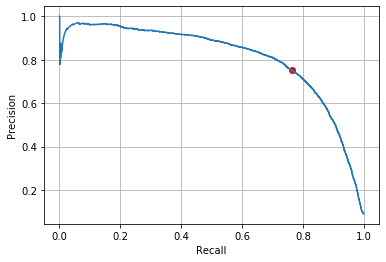

In [70]:
threshold = -2500
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plot_recall_vs_precision(recalls, precisions)

3370.0194991439557


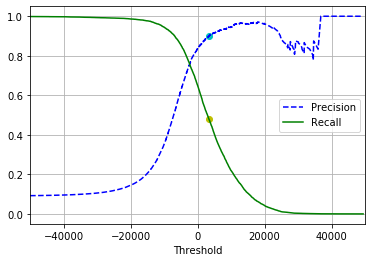

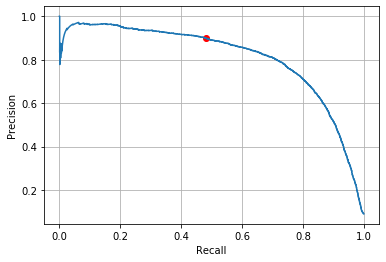

In [71]:
# Let's see the case for 90% precision
threshold = thresholds[np.argmax(precisions >= 0.90)]
print(threshold)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plot_recall_vs_precision(recalls, precisions)

In [72]:
y_train_pred_90 = (y_scores >= threshold)
print("Precision:", precision_score(y_train_5, y_train_pred_90))
print("Recall:", recall_score(y_train_5, y_train_pred_90))

Precision: 0.9000345901072293
Recall: 0.4799852425751706


## The ROC Curve

In [73]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

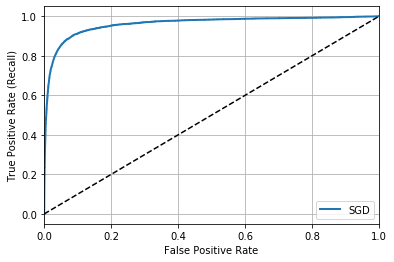

In [74]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim(0, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid()
    plt.legend(loc="lower right")
    plt.show()
plot_roc_curve(fpr, tpr, label="SGD")

####  Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier
#### One way to compare classifiers is to measure the area under the curve (AUC). A per‐ fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [75]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### Use Recall vs Precision curve whenever the positive class is rare (like this examples, there are only a few 5's), otherwise use ROC curve
#### Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier.

In [76]:
# RandomForestClassifier class does not have a decision_function(), instead has a predict_proba()
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba", n_jobs=-1)

# to plot a ROC curve we need scores, not probabilites
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

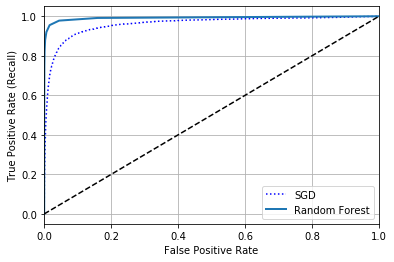

In [77]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")

In [78]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

In [79]:
def scores(a, b):
    print("Precision score: {}".format(precision_score(a, b)))
    print("Recall score: {}".format(recall_score(a, b)))
    print("F1-score: {}".format(f1_score(a, b)))

In [80]:
y_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, n_jobs=-1)
scores(y_train_5, y_pred_forest)

Precision score: 0.986046511627907
Recall score: 0.8212506917542889
F1-score: 0.8961352657004831


## Multiclass Classification

#### If you want to classify multiple classes, there is the posibility to use a binary clasifier, there are two techniques in order to achieve this: One versus all (OvA) where you classify every instance as instance or no instance and there is One versus one (OvO) where you train a binary classifier for every pair of instances.

#### Scikit learns runs by default OvA, let's check SGDCClassifier

In [81]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

#### Scikit learn trained 10 binary classifiers, got their scores for the image and selected the maximum, let's see the scores

In [82]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [83]:
print("Index of maximum:", np.argmax(some_digit_scores))
print("Clases:", sgd_clf.classes_)
print("Result:", sgd_clf.classes_[3])

Index of maximum: 3
Clases: [0 1 2 3 4 5 6 7 8 9]
Result: 3


#### If we want to use OvO classifier we can do the following

In [84]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, n_jobs=-1))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [85]:
len(ovo_clf.estimators_)

45

#### Training a RandomForestClassifier is easy as this because it can directly classify instances into multiple classes

In [86]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/home/julio/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=uint8)

In [87]:
# Let's get the list of probabilities for each digit given some_digit
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [88]:
# Let's evaluate our classifiers
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.87082583, 0.87089354, 0.88628294])

In [89]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.94116177, 0.93949697, 0.94374156])

In [90]:
# This is a nice score but there is room for improvement, let's do some feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.89957009, 0.89344467, 0.89963495])

## Error analysis

#### When you have decided which model to use, there is alway room for improvement so let's see how we can improve our model.
#### First let's take a look to the confusion  matrix

In [91]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3,  n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

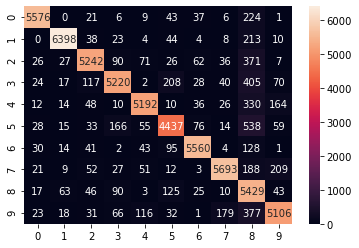

In [92]:
# Lets visualize it in a more convenient way
sn.heatmap(conf_mx, annot=True, fmt='g')

#### Most numbers are on the diagonal so that's a sign of a good model, the brighter means the more correctly classified. As we can see, the number 5 does not perform that well as the others.
#### To focus on the errors, let's divide each class by the number of images of the corresponding class so we can compare rates instead of absolute number of errors (which would make abundant classes look unfairly bad)

In [93]:
row_sums = conf_mx.sum(axis = 1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

#### Let's fill the diagonal with zeros to keep only the errors

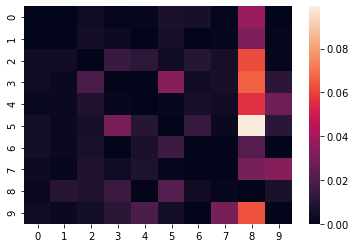

In [94]:
np.fill_diagonal(norm_conf_mx, 0)
sn.heatmap(norm_conf_mx)

#### The 8 column is quite bright meaning that images get misclassified as 8's. However the row for the 8 es somewhat dark so the 8 class is properly classified as 8. The goal here would be to reduce the false 8's.
#### Let's see the reason why 3 and 5 (symetrically) are classified as the other class.

In [95]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

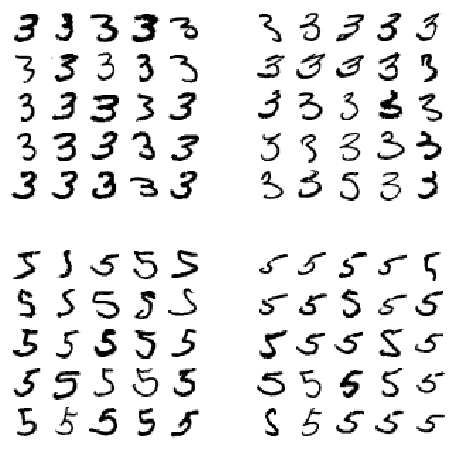

In [96]:
cl_a, cl_b = 3, 5 # A = 3, B = 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # Class A predicted A
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # Class A predicted B
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # Class B predicted A
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # Class B predicted B

plt.figure(figsize=(8, 8))
# Plot first 25 coincidences
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5) 
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5) 
plt.show()

#### The two 5x5 blocks on the left show digits classified as 3's, and the two blocks on the right show images classified as 5's. The diagonal are the numbers correctly classified

## Multilabel Classification

#### Let's create a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9) and the second indicates whether or not it is odd.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [11]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [14]:
knn_clf.predict([some_digit])

array([[False,  True]])

#### Let's evaluate the multilabel classifier using an average of the F1 score

In [17]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multioutput Classification

#### This one is just a generalization of the multilabel classification: instead of having each instance two output values, we have multiple output values
#### This example we'll use MNIST dataset with noisy images on the train set and clean images on the test set so we can train a model to clean images (output will be an image, multiple output values)

In [66]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Text(0.5, 1.0, 'y_test_mod[4]')

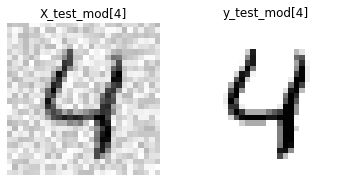

In [108]:
some_noisy_digit_image = X_test_mod[4].reshape(28, 28)
some_clean_digit_image = y_test_mod[4].reshape(28, 28)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(some_noisy_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
ax1.axis("off")
ax1.set_title("X_test_mod[4]")
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(some_clean_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
ax2.axis("off")
ax2.set_title("y_test_mod[4]")

#### Now let's train the classifier and make it clean this image

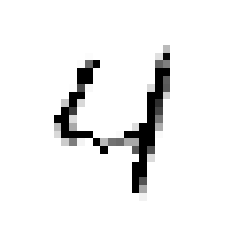

In [110]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[4]])
plt.imshow(clean_digit.reshape(28, 28), cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

#### Very close to the target!!